In [1]:
import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import math
import torch
import matplotlib.pyplot as plt
import mediapy
from icecream import ic
from data import loader
import random
import time
from tqdm import tqdm
import numpy as np
from utils import cam_util
from utils.train_util import *
from models.ingp_color import *
from fused_ssim import fused_ssim
from pathlib import Path, PosixPath
from utils.args import Args
import pickle
import json
from utils import safe_math
from delaunay_rasterization.internal.render_err import render_err
import imageio
import cv2

args = Args()
args.tile_size = 16
args.sh_deg = 3
args.output_path = Path("output")
args.densify_interval = 500
args.budget = 1_000_000
args.num_samples = 200
args.densify_start = 2000
args.densify_end = 5000
args.freeze_start = 100000
args.iterations = 7000
args.sh_interval = 500
args.image_folder = "images_4"
args.eval = True
args.dataset_path = Path("/optane/nerf_datasets/360/bicycle")
args.output_path = Path("output/test/")
args.s_param_lr = 0.025
args.rgb_param_lr = 0.025
args.sh_param_lr = 0.0025
args.delaunay_start = 0

args.log2_hashmap_size = 22
args.per_level_scale = 2
args.L = 10
args.density_offset = -1
args.light_offset = -1

args.hidden_dim = 64
args.scale_multi = 1.0

args.vertices_lr = 1e-4
args.lr_delay = 50
args.final_vertices_lr = 1e-6
args.vertices_lr_max_steps = args.iterations

args.vertices_lr_delay_multi = 1e-8
# args.network_lr = 0.00125
# args.final_network_lr = 0.000125
args.encoding_lr = 0.00125
args.final_encoding_lr = 0.000125
# args.lambda_dist = 1e-2

# args.vertices_lr_delay_mult = 0.01
# args.network_lr = 1e-3
# args.final_network_lr = 1e-5
args.network_lr = 0.00125
args.final_network_lr = 0.000125
# args.encoding_lr = 1e-2
# args.final_encoding_lr = 1e-3

args.lambda_ssim = 0.1
args.clone_lambda_ssim = 0.1

args.clip_multi = 1e-4
args.weight_decay = 0.01
args.render_size_min = 0
args.vertices_beta = [0.9, 0.99]
args.net_weight_decay = 0.0
args.contract_vertices = False
args.vertices_warmup = 0
args.hashmap_dim = 4
args.min_clone_size = 1e-3

# args.lambda_dist = 1e-3
# args.ladder_p = -0.5
# args.pre_multi = 4000.0
args.lambda_dist = 1e-2
args.ladder_p = -0.25
args.pre_multi = 10000

args.split_std = 0.1
args.split_mode = "barycentric"
args.clone_schedule = "linear"

/home/dronelab/delaunay_rasterization


/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
device = torch.device('cuda')
vertices = torch.randn((100, 3), device=device)
center = torch.zeros((3), device=device)
model = Model(vertices, center, 1, num_lights=1)
tet_optim = TetOptimizer(model, **args.as_dict())

/home/dronelab/miniconda3/envs/gaussian_splatting/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


In [3]:
def plot_fn(base_color_raw, lights, light_offset, dir_offset):
    width  = 400
    height = 200
    base_color, light_colors, light_roughness, reflection_coords = activate_lights(
        base_color_raw, lights, light_offset, dir_offset)
    reflection_dirs = to_sphere(reflection_coords)
    # reflection_dirs = lambert_to_sphere(reflection_coords)

    phi_vals   = torch.linspace(-np.pi, np.pi, width)
    theta_vals = torch.linspace(0, np.pi, height)

    p, t = torch.meshgrid(phi_vals, theta_vals, indexing='xy')
    view_dirs = torch.stack([
        torch.sin(t) * torch.cos(p),
        torch.sin(t) * torch.sin(p),
        torch.cos(t)
    ], dim=-1).to(device)
    results = light_function(base_color, 
                             reflection_dirs, 
                             light_colors, 
                             light_roughness, 
                             view_dirs.reshape(-1, 1, 3))
    results_2d = results.reshape(height, width, 3).detach().cpu().numpy()
    results_2d = results_2d / results_2d.max()

    # Plot using matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(results_2d, origin='upper', extent=(-180, 180, -90, 90))
    plt.title('Panorama of light_function across view directions')
    plt.xlabel('Longitude (degrees)')
    plt.ylabel('Latitude (degrees, top=North pole, bottom=South pole)')
    plt.axis('on')
    plt.show()

def plot_compare(gt_base_color_raw, gt_lights, model):
    plot_fn(gt_base_color_raw[:1], gt_lights[:1], model.light_offset, model.dir_offset)

    output = model.compute_batch_features(model.vertices, model.indices, 0, model.indices.shape[0])
    base_color_raw = output[:, :3]
    density = torch.exp(output[:, 3:4] + model.density_offset)
    lights = output[:, 4:].reshape(-1, model.num_lights, 6)
    plot_fn(base_color_raw[:1], lights[:1], model.light_offset, model.dir_offset)

In [4]:
gt_lights = 2*torch.randn((model.indices.shape[0], model.num_lights, 6), device=device)
gt_lights[:, :, 3:4] += 0.01
gt_base_color_raw = torch.randn((model.indices.shape[0], 3), device=device)


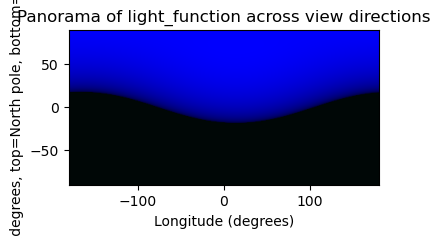

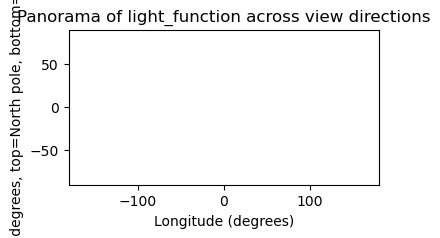

In [5]:
plot_compare(gt_base_color_raw, gt_lights, model)

tensor(0.4960, device='cuda:0', grad_fn=<MeanBackward0>)


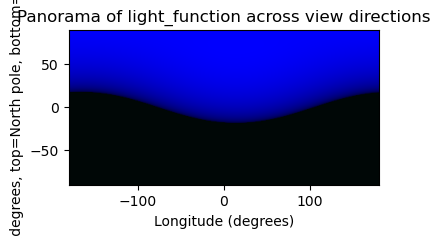

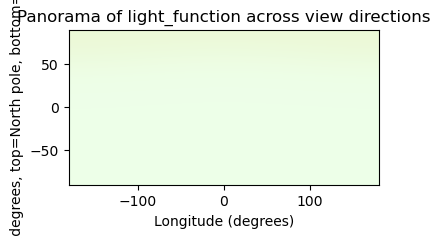

tensor(0.0046, device='cuda:0', grad_fn=<MeanBackward0>)


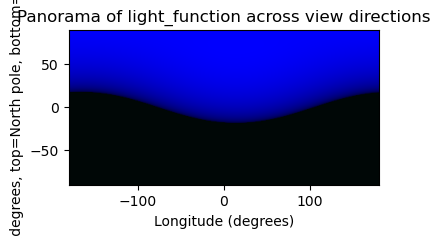

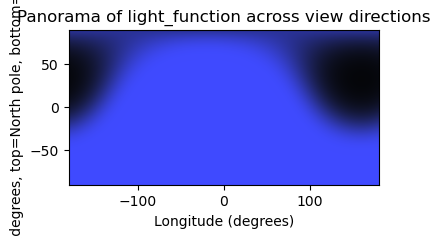

tensor(0.0621, device='cuda:0', grad_fn=<MeanBackward0>)


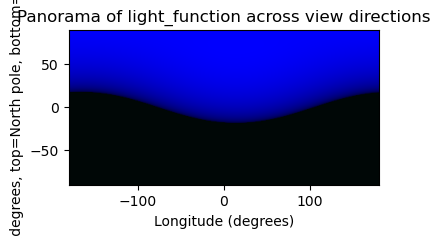

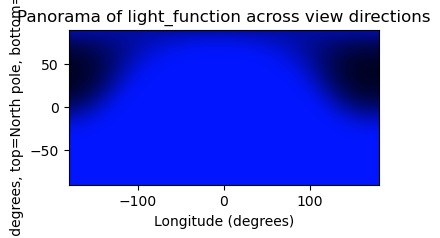

tensor(0.0457, device='cuda:0', grad_fn=<MeanBackward0>)


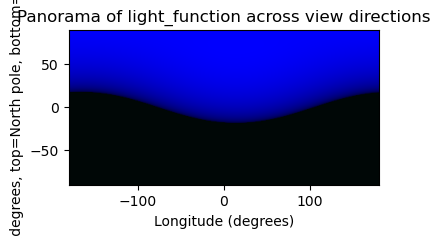

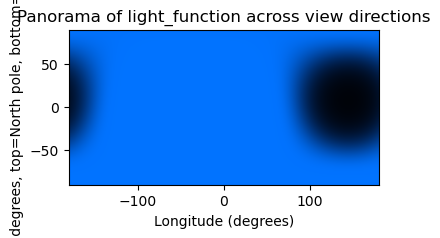

tensor(0.0402, device='cuda:0', grad_fn=<MeanBackward0>)


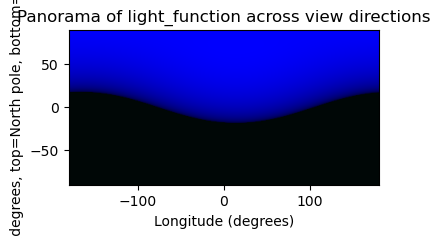

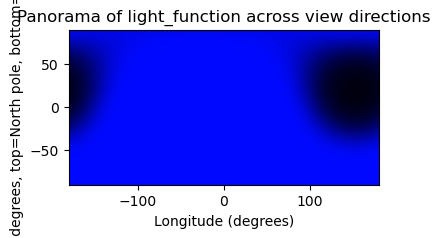

tensor(0.0816, device='cuda:0', grad_fn=<MeanBackward0>)


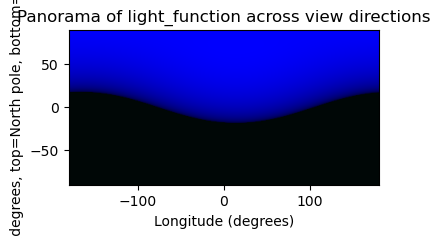

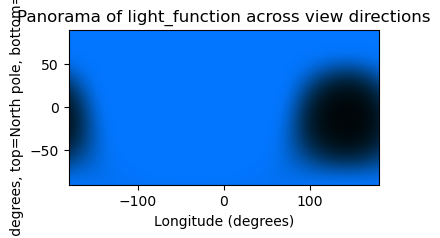

tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>)


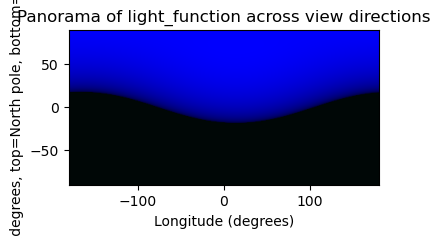

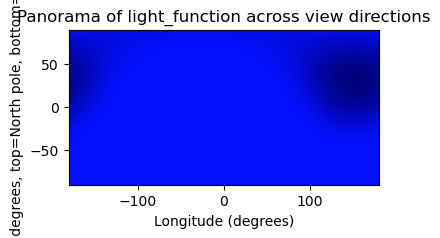

tensor(0.0052, device='cuda:0', grad_fn=<MeanBackward0>)


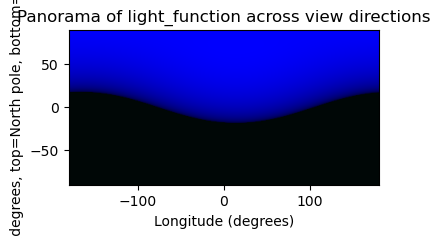

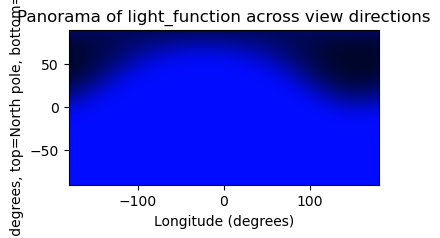

tensor(0.0203, device='cuda:0', grad_fn=<MeanBackward0>)


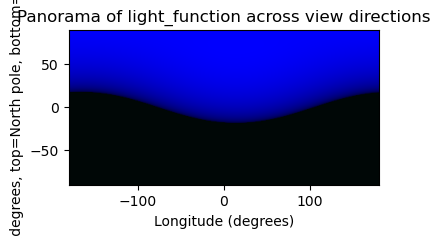

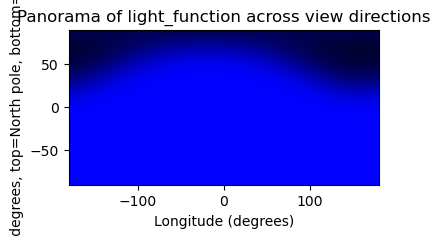

tensor(0.0525, device='cuda:0', grad_fn=<MeanBackward0>)


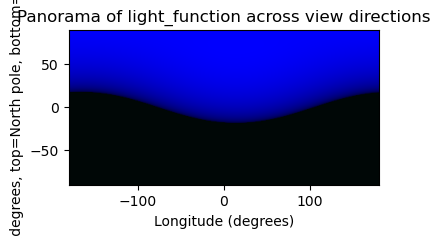

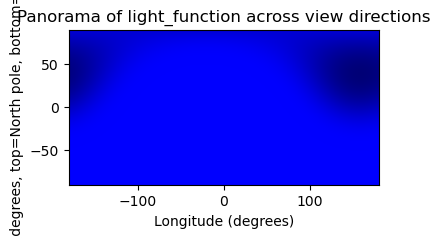

In [6]:
for i in range(5000):
    camera = lambda x: x
    camera.camera_center = 5*torch.randn((3), device=device)
    output = model.get_cell_values(camera)
    color = output[0, :3]
    gt_colors = compute_light_color(
        gt_base_color_raw, gt_lights, model.vertices, model.indices,
        camera.camera_center, model.light_offset, model.dir_offset)
    gt_color = gt_colors[0]
    loss = (color - gt_color).abs().mean()
    loss.backward()
    tet_optim.main_step()
    tet_optim.main_zero_grad()
    if i % 500 == 0:
        print(loss)
        plot_compare(gt_base_color_raw, gt_lights, model)
